# About this notebook

**In this notebook we will analyze how Prophet creates predictions for new dates. Firstly, we will train model for synthetic data and then we will go step by step through prediction process.**


# Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Synthetic data generation

In [3]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    returns: y = 1/3 * t + 1/3 * (t * Sin(t) + 200 + noise) + 
                            + 1/3 * (100 * Sin(t // period) + 100 + 2*t)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

# Generate features

In [4]:
np.random.seed(123)
Time = np.arange(0, 200)
Exog = np.concatenate([f_1(Time), f_2(Time), f_3(Time, period=12)], axis = 1)

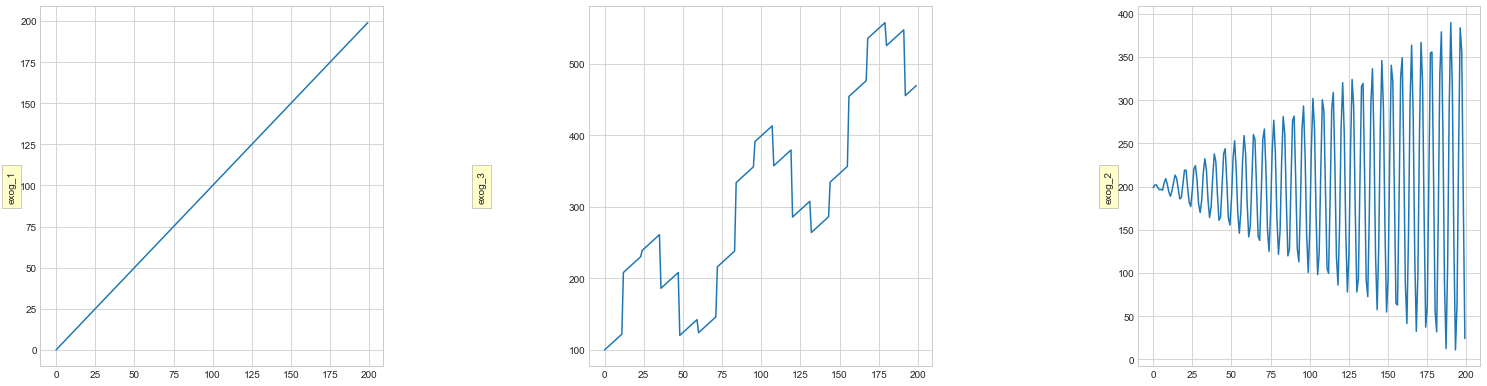

In [5]:
box = dict(facecolor='yellow', pad=5, alpha=0.2)

fig, ((ax1, ax2, ax3, )) = plt.subplots(1, 3, figsize = (10, 5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots

fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)

ax1.plot(Time,Exog[:,0])
ax1.set_ylabel('exog_1', bbox=box)


ax3.set_ylabel('exog_2',bbox=box)
ax3.plot(Time,Exog[:,1])

labelx = -0.3  # axes coords

ax2.plot(Time,Exog[:,2])
ax2.set_ylabel('exog_3', bbox=box)
ax2.yaxis.set_label_coords(labelx, 0.5)


plt.show()

# Generate and plot time-series

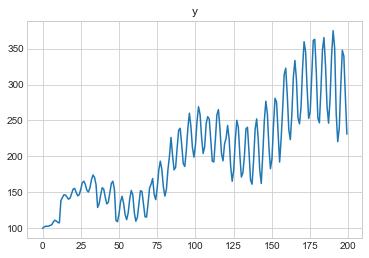

In [6]:
y = generate_ts_1(Exog)

plt.plot(Time, y)
plt.title("y")
plt.show()

# Data preprocessing for Prophet

Prophet requires data with specific format. The input to Prophet is always a dataframe with two columns: ds and y.
- The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp
- The y column must be numeric, and represents the measurement we wish to forecast.

In [7]:
data = pd.DataFrame(y)
data.columns = ["y"]
data["ds"] = pd.date_range(start='1/1/2018', periods=len(data), freq='M')

In [8]:
print("Shape of the data: {0}".format(data.shape))

Shape of the data: (200, 2)


In [9]:
data.head()

,y,ds
0,99.638123,2018-01-31
1,101.612939,2018-02-28
2,102.700524,2018-03-31
3,102.639022,2018-04-30
4,102.798063,2018-05-31


**Prepare dataframe of exogenous regressors with the same dates**

In [10]:
exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

In [11]:
print("Shape of the exogenous features: {0}".format(exog.shape))

Shape of the exogenous features: (200, 4)


In [12]:
exog.head()

,f1,f2,f3,ds
0,0.0,198.914369,100.0,2018-01-31
1,1.0,201.838816,102.0,2018-02-28
2,2.0,202.101573,104.0,2018-03-31
3,3.0,198.917065,106.0,2018-04-30
4,4.0,196.394190,108.0,2018-05-31


# Train-test split

In [13]:
N = 100

data_train = data.iloc[:N]
data_test = data.iloc[N:]

exog_train = exog.iloc[:N]
exog_test = exog.iloc[N:]

Remove target variable from the test dataset

In [14]:
y_test = data_test["y"].values
del data_test["y"]

# What is the Prophet model?

First of all we will write final formula for prediction and then we will go step-by-step, how to obtain this prediction.

<img src="pngs/final_formula_for_prophet.png" width=100%>

Prophet model has 5 training parameters: 
- $k$ - base trend, 
- $m$ - offset parameter, 
- $\delta$ - changing of trend in changepoints, 
- $\beta$ - parameters for Fourier series (seasonal component) and extra regressors (exogenous features),
- $\sigma$ - level of noise.

Formula above doesn't take into account some detailes, for example that time is standartized.



<img src="pngs/stan.png" width=100%>

<img src="pngs/changepoints_process.png" width=100%>

<img src="pngs/changepoints_prior_scale.png" width=100%>

Let's go through all of these components.

# Example of Prophet model with two exogenous features and two seasonal components

Let's look at the model in which we will make a prediction for first three points from the test data. 
1. We consider two multiplicative seasonal components (yearly, montly) with fourier order is equal to one
2. We add two exogenous regressors (out of three that were used to create target (y) time-series): one with multiplicative mode, another one with additive mode.

In [15]:
data_train.head(5)

,y,ds
0,99.638123,2018-01-31
1,101.612939,2018-02-28
2,102.700524,2018-03-31
3,102.639022,2018-04-30
4,102.798063,2018-05-31


In [16]:
exog_train.head(5)

,f1,f2,f3,ds
0,0.0,198.914369,100.0,2018-01-31
1,1.0,201.838816,102.0,2018-02-28
2,2.0,202.101573,104.0,2018-03-31
3,3.0,198.917065,106.0,2018-04-30
4,4.0,196.394190,108.0,2018-05-31


In [17]:
# Create joined dataset with 2 regressors
data_train_joined_2_regressor = pd.merge(data_train, exog_train[["f1", "f2", "ds"]], 
                                         on = "ds")

data_test_joined_2_regressor = pd.merge(data_test, exog_test[["f1", "f2", "ds"]], 
                                        on = "ds")

# Take first 3 points for prediction
data_test_joined_2_regressor = data_test_joined_2_regressor[:3].copy()

print('Train shape: {0}'.format(data_train_joined_2_regressor.shape))
print("Test shape: {0}".format(data_test_joined_2_regressor.shape))

Train shape: (100, 4)
Test shape: (3, 3)


In [18]:
data_train_joined_2_regressor.head()

,y,ds,f1,f2
0,99.638123,2018-01-31,0.0,198.914369
1,101.612939,2018-02-28,1.0,201.838816
2,102.700524,2018-03-31,2.0,202.101573
3,102.639022,2018-04-30,3.0,198.917065
4,102.798063,2018-05-31,4.0,196.394190


In [19]:
data_test_joined_2_regressor

,ds,f1,f2
0,2026-05-31,100.0,150.005491
1,2026-06-30,101.0,243.676717
2,2026-07-31,102.0,302.184597


## Prophet model initializiation

**Create model with only one changepoint**

In [20]:
from fbprophet import Prophet

model = Prophet(n_changepoints = 1)

**Add two seasonal components with multiplicative mode**

In [21]:
model.add_seasonality(name='yearly', period = 12, fourier_order = 1, 
                      prior_scale = 0.1, mode = 'multiplicative')
model.add_seasonality(name='monthly', period = 30, fourier_order = 1, 
                      prior_scale = 0.1, mode = 'multiplicative')

**Add one regressor with multiplicative mode and one regressor with additive mode**

In [22]:
model.add_regressor("f1", mode = "multiplicative")
model.add_regressor("f2", mode = "additive")

**Fit our model**

In [23]:
model.fit(data_train_joined_2_regressor)

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


**Make a prediction**

In [24]:
forecast = model.predict(data_test_joined_2_regressor)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2026-05-31,174.310215,200.236143,220.439298,174.310215,174.310215,-16.443815,-16.443815,-16.443815,-16.443815,...,0.168933,0.168933,0.168933,0.300308,0.300308,0.300308,0.002940,0.002940,0.002940,210.213106
1,2026-06-30,175.038503,230.806699,250.848842,175.038503,175.038503,14.686144,14.686144,14.686144,14.686144,...,0.168933,0.168933,0.168933,0.296970,0.296970,0.296970,-0.002940,-0.002940,-0.002940,241.705875
2,2026-07-31,175.791066,250.547581,270.334977,175.791066,175.791066,34.130193,34.130193,34.130193,34.130193,...,0.151112,0.151112,0.151112,0.286122,0.286122,0.286122,0.001488,0.001488,0.001488,260.218885


## Check model prediction manually 

**Let's see the parameters of the model**

In [25]:
model.params

{'k': array([[0.13645734]]),
 'm': array([[0.50168957]]),
 'delta': array([[0.14458096]]),
 'sigma_obs': array([[0.03056742]]),
 'beta': array([[-0.00211694,  0.00294037, -0.1816637 , -0.01242603,  0.07378385,
          0.0526053 ]])}

At first Prophet transforms dataframe to the special format (we use prophet's function) - it just takes initial dataframe and does some transformations and preprocessing: 
- scaling of the target (y_scaled), 
- creates columns "t", that is just scale of time to range \[0, 1\], 
- standartization of exogenous features (subtraction of training mean and division by training variance per feature)

In [26]:
df_train = model.setup_dataframe(data_train_joined_2_regressor)
df_train.head(5)

,y,ds,f1,f2,floor,t,y_scaled
0,99.638123,2018-01-31,-1.706220,-0.013874,0,0.000000,0.383088
1,101.612939,2018-02-28,-1.671751,0.057159,0,0.009299,0.390681
2,102.700524,2018-03-31,-1.637282,0.063541,0,0.019595,0.394862
3,102.639022,2018-04-30,-1.602813,-0.013808,0,0.029558,0.394626
4,102.798063,2018-05-31,-1.568344,-0.075087,0,0.039854,0.395237


In [27]:
df_test = model.setup_dataframe(data_test_joined_2_regressor)
df_test.head(5)

,ds,f1,f2,floor,t
0,2026-05-31,1.740690,-1.201839,0,1.010296
1,2026-06-30,1.775159,1.073375,0,1.020259
2,2026-07-31,1.809628,2.494494,0,1.030555


Let's check standartization of the time

In [28]:
# Start of the time
start = data_train_joined_2_regressor["ds"].min()

# Timedelta to the end of training data
t_scale = data_train_joined_2_regressor["ds"].max() - start 

# scaled time to the range [0, 1]
t = ((data_test_joined_2_regressor["ds"] - start) / t_scale).values
print("Standartized time: {0}".format(t))

Standartized time: [1.01029558 1.02025905 1.03055463]


In [29]:
print("Standartized time by prophet: {0}".format(df_test["t"].values))

Standartized time by prophet: [1.01029558 1.02025905 1.03055463]


Let's check standartization of the regressors

In [30]:
mu_train = data_train_joined_2_regressor['f1'].mean()
std_train = data_train_joined_2_regressor['f1'].std()

print("Standartized f1 regressor by our calculations: {0}".format(
    ((data_test_joined_2_regressor['f1'] - mu_train) / std_train).values))

Standartized f1 regressor by our calculations: [1.74068952 1.77515862 1.80962772]


In [31]:
print("Standartized f1 regressor by prophet: {0}".format(df_test["f1"].values))

Standartized f1 regressor by prophet: [1.74068952 1.77515862 1.80962772]


**As we can see we have obtained the same result.**

**So, we obtained standartization of features and time, using parameters $\mu$ and $\sigma$ that were calculated using train data. The results are the similar.**

In [32]:
changepoint_ts = model.changepoints_t
print("Changepoints: {0}".format(changepoint_ts))

Changepoints: [0.79840585]


**This is the changepoint that was obtained for already standartized time.**

**Next step is to obtain $k$ and $m$ as initial points for stan optimization.**

<img src="pngs/trend_k_m.png" width=100%>

In [33]:
# Just extracted the indices of the minimum and maximum
i0, i1 = df_train['ds'].idxmin(), df_train['ds'].idxmax()

# Calculate the time difference for a standardized time
T = df_train['t'].iloc[i1] - df_train['t'].iloc[i0] 

# Calculate k
k = (df_train['y_scaled'].iloc[i1] - df_train['y_scaled'].iloc[i0]) / T

# Calculate m
m = df_train['y_scaled'].iloc[i0] - k * df_train['t'].iloc[i0]

print("initial value for k: {0}".format(k))
print("initial value for m: {0}".format(m))

initial value for k: 0.3815584795973132
initial value for m: 0.3830881532500982


**After stan optimization we will have the following parameters.**

In [34]:
k = np.nanmean(model.params['k'])
m = np.nanmean(model.params['m'])

print("Value for k after stan optimization: {0}".format(k))
print("Value for m after stan optimization: {0}".format(m))

Value for k after stan optimization: 0.13645733525557904
Value for m after stan optimization: 0.5016895722290727


**Calculating deltas and gammas:**

<img src="pngs/trend_gamma_delta.png" width=100%>

In [35]:
deltas = np.nanmean(model.params['delta'], axis = 0)
gammas = -changepoint_ts * deltas

**The code below describes how to calculate trend component of prediction.**

<img src="pngs/trend_middle.png" width=100%>

In [36]:
gammas = -changepoint_ts * deltas

k_t = k * np.ones_like(t)
m_t = m * np.ones_like(t)

for s, t_s in enumerate(changepoint_ts):
    indx = t >= t_s
    k_t[indx] += deltas[s]
    m_t[indx] += gammas[s]

trend = k_t * t + m_t

**After that trend component calculates as follows: (In this case we have lower bound  - parameter floor - is equal to zero)**

<img src="pngs/trend_full.png" width=100%>

In [37]:
floor = 0
trend = trend * model.y_scale + floor

In [38]:
print("Manually calculated trend: {0}".format(trend))

Manually calculated trend: [174.31021537 175.03850281 175.79106649]


In [39]:
print("Trend calculated by Prophet: {0}".format(forecast.trend.values))

Trend calculated by Prophet: [174.31021537 175.03850281 175.79106649]


# Multiplicative and additive terms

**As we can see, we have obtained the same results. So, now the next step is to find out how to calculate seasonal_components. To do this we will explore 2 functions, that are used to predict seasonal components.**

<img src="pngs/multiplicative_terms.png" width=100%>

<img src="pngs/additive_terms.png" width=100%>

In [40]:
seasonal_components = model.predict_seasonal_components(df_test)
seasonal_components.head(5)

,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,f1,...,f2_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper
0,-16.443815,-16.443815,-16.443815,-16.443815,-16.443815,-16.443815,0.128435,0.128435,0.128435,0.128435,...,-16.443815,0.168933,0.168933,0.168933,0.300308,0.300308,0.300308,0.002940,0.002940,0.002940
1,14.686144,14.686144,14.686144,14.686144,14.686144,14.686144,0.130978,0.130978,0.130978,0.130978,...,14.686144,0.168933,0.168933,0.168933,0.296970,0.296970,0.296970,-0.002940,-0.002940,-0.002940
2,34.130193,34.130193,34.130193,34.130193,34.130193,34.130193,0.133521,0.133521,0.133521,0.133521,...,34.130193,0.151112,0.151112,0.151112,0.286122,0.286122,0.286122,0.001488,0.001488,0.001488


In [41]:
seasonal_features, _, component_cols, _ = model.make_all_seasonality_features(df_test)

In [42]:
seasonal_features.head(5)

,yearly_delim_1,yearly_delim_2,monthly_delim_1,monthly_delim_2,f1,f2
0,-8.681856e-13,1.000000,-0.951057,0.309017,1.740690,-1.201839
1,-7.832139e-13,-1.000000,-0.951057,0.309017,1.775159,1.073375
2,5.000000e-01,0.866025,-0.866025,0.500000,1.809628,2.494494


**In the dataframe seasonal features we have the following data:
First two columns are responsable for yearly seasonal component, and so we have fourier coefficients in this columns for yearly component. In The 3rd and the 4-th columns fourier coefficient for monthly seasonal component, and finally in the 5-th and the 6-th columns we have just standartized regressors.**


**Formulas for calculating coefficients in the columns, that are responsible for seasonal components are the following: this formulas for columns for one seasonal component**

$$
A[i, j] = [\text{j is even}]*Cos(2 \pi i (j + 1) / period) + [\text{j is odd}]*Sin(2 \pi i (j + 1) / period)
$$

where $i$ is a time index and $j$ is a fourier order for the component

**There we create t, to calculate fourier series**

In [43]:
t = np.array(
    (data_test_joined_2_regressor["ds"] - pd.datetime(1970, 1, 1))
    .dt.total_seconds()
    .astype(np.float)
) / (3600 * 24.)
print("Time in month passed from 01.01.1970 for every test point: {0}".format(t))

Time in month passed from 01.01.1970 for every test point: [20604. 20634. 20665.]


**That formula calculates the fourier coefficients for yearly seasonal component.**

In [44]:
model.seasonalities

{'yearly': {'period': 12,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'},
 'monthly': {'period': 30,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'}}

<img src="pngs/fourier.png" width=50%>

In [45]:
period = model.seasonalities['yearly']["period"]
series_order = model.seasonalities["yearly"]["fourier_order"]

np.column_stack([
    fun((2.0 * (i + 1) * np.pi * t / period))
    for i in range(series_order)
    for fun in (np.sin, np.cos)
])

array([[-8.68185634e-13,  1.00000000e+00],
       [-7.83213903e-13, -1.00000000e+00],
       [ 5.00000000e-01,  8.66025404e-01]])

**Note that for the seasonal component were obtained the same coefficients, + the regressor is also the same.**

**Now we will understand how to obtain the matrix component_cols**

In [46]:
component_cols

component,additive_terms,extra_regressors_additive,extra_regressors_multiplicative,f1,f2,monthly,multiplicative_terms,yearly
col,,,,,,,,
0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,1,0
3,0,0,0,0,0,1,1,0
4,0,0,1,1,0,0,1,0
5,1,1,0,0,1,0,0,0


**It's just a cross-tab matrix that shows for each feature what columns it met in seasonal_matrix + there we  added some special names to distinguish between regressors and not regressors and so on. **

**Now we understand how to take into account "additive_terms" and "multiplicative_terms" for the final prediction. Note that these two columns will always be in obtained dataframes for seasonal components, and their sum will always be equal to 1.**

In [47]:
# Extract the data
X = seasonal_features.values

# For each seasonal component we calculate
for component in component_cols.columns:
    
    # Here, in fact, we leave the beta non-zero only in those positions where we have 1
    # This is equivalent to the fact that we just made up a mask so that later in the matrix seasonal_features take
    # only the parameters we need
    beta_c = model.params['beta'] * component_cols[component].values
    
    # This is a basic dot product, that is, for each date it's easy
    # multiply the scaled value by the trained beta and add
    # only the parameters that we need
    comp = np.matmul(X, beta_c.transpose())
    
    # If we have additive feature, then we should scale, that is also obvious
    if component in model.component_modes['additive']:
         comp *= model.y_scale
    
    # Exactly this will be in  'multiplicative' and 'additive'
    df_test[component] = np.nanmean(comp, axis=1)
    

In [48]:
df_test

,ds,f1,f2,floor,t,additive_terms,extra_regressors_additive,extra_regressors_multiplicative,monthly,multiplicative_terms,yearly
0,2026-05-31,0.128435,-16.443815,0,1.010296,-16.443815,-16.443815,0.128435,0.168933,0.300308,0.002940
1,2026-06-30,0.130978,14.686144,0,1.020259,14.686144,14.686144,0.130978,0.168933,0.296970,-0.002940
2,2026-07-31,0.133521,34.130193,0,1.030555,34.130193,34.130193,0.133521,0.151112,0.286122,0.001488


**Let us denote by $r_1$, $r_2$ standartized value for regressor $f_1$ anf $f_2$ respectively.**
**$\phi_{sin_Y}$, $\phi_{cos_Y}$ denotes the fourier coefficient for yearly seasonal component.**
**$\phi_{sin_M}$, $\phi_{cos_M}$ denotes the fourier coefficient for monthly seasonal component.**

**Then the multiplicative term in this case will be just $\phi_{sin_Y} * \beta_{0} + \phi_{cos_Y} * \beta_{1}$ + $\phi_{sin_M} * \beta_{2} + \phi_{cos_M} * \beta_{3} + r_1 * \beta_4$**
**And additive will be $r_2 \beta_5$**

**Let's check this:**

<img src="pngs/additive_product.png" width=100%>

In [49]:
additive_terms = model.params["beta"].squeeze()[5] * seasonal_features["f2"] * model.y_scale
print("Manually calculated additive terms: {0}".format(additive_terms.values))

Manually calculated additive terms: [-16.44381468  14.68614412  34.13019323]


In [50]:
print("Additive terms calculated by Prophet: {0}".format(
    seasonal_components["additive_terms"].values))

Additive terms calculated by Prophet: [-16.44381468  14.68614412  34.13019323]


**We have obtained the same additive terms.**

<img src="pngs/multiplicative-product.png" width=100%>

In [51]:
multiplicative_terms = (model.params["beta"].squeeze()[0] * seasonal_features["yearly_delim_1"] + 
        model.params["beta"].squeeze()[1] * seasonal_features["yearly_delim_2"] + 
        model.params["beta"].squeeze()[2] * seasonal_features["monthly_delim_1"] + 
        model.params["beta"].squeeze()[3] * seasonal_features["monthly_delim_2"] + 
        model.params["beta"].squeeze()[4] * seasonal_features["f1"])
print("Manually calculated multiplicative terms: {0}".format(multiplicative_terms.values))

Manually calculated multiplicative terms: [0.30030773 0.29697025 0.28612162]


In [52]:
print("Multiplicative terms calculated by Prophet: {0}".format(
    seasonal_components["multiplicative_terms"].values))

Multiplicative terms calculated by Prophet: [0.30030773 0.29697025 0.28612162]


**Additive и multiplicative are the same. So, the final prediction is:**
# Final prediction

<img src="pngs/final_product.png" width=100%>

In [53]:
prediction = trend * (1 + multiplicative_terms) + additive_terms
print("Manually calculated prediction: {0}".format(prediction.values))

Manually calculated prediction: [210.21310624 241.70587508 260.21888526]


In [54]:
forecast = model.predict(data_test_joined_2_regressor)
print("Prediction calculated by Prophet: {0}".format(forecast["yhat"].values))

Prediction calculated by Prophet: [210.21310624 241.70587508 260.21888526]


**Everything is fine. :-)**